In [1]:
import pandas as pd
import panel as pn
import numpy as np
from sqlalchemy import create_engine
from datetime import date, timedelta
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set

pn.extension('tabulator')

engine = create_engine("mysql+pymysql://root:@localhost:3306/stock")
const = engine.connect()
engine = create_engine("sqlite:///c:\\ruby\\portmy\\db\\development.sqlite3")
conmy = engine.connect()

data_path = "../data/"
csv_path = "\\Users\\User\\iCloudDrive\\"
box_path = "\\Users\\User\\Dropbox\\"

today = date.today()
today

datetime.date(2022, 1, 29)

### Set today = last closed business day

In [2]:
today = today - timedelta(days=1)
today

datetime.date(2022, 1, 28)

### Restart and Run All Cells

In [3]:
cols = 'name period shares unit_cost cost_amt base_amt pct'.split()

In [4]:
format_dict = {
    'shares':'{:,}','div_rnk':'{:,}','amt_rnk':'{:,}',  
    'price':'{:.2f}','unit_cost':'{:.2f}','mkt_price':'{:.2f}',
    'cost_amt':'{:,.2f}','div_amt':'{:,.2f}','mkt_amt':'{:,.2f}',
    'profit':'{:,.2f}','base_amt':'{:,.2f}','cumsum':'{:,.2f}',
    'dividend':'{:.4f}',    
    'pct':'{:,.2f}%','cost_pct':'{:,.2f}%','mkt_pct':'{:,.2f}%','pft_pct':'{:,.2f}%',
}

### Change period of stock in table buy

In [32]:
name = 'TU'
sql = """
SELECT * 
FROM buy 
WHERE name = '%s' 
"""
sql = sql % name
df = pd.read_sql(sql, const)
df

,name,date,volbuy,price,volsell,volbal,active,dividend,period,grade
0,TU,2021-08-19,18000.0,20.8,0.0,0.0,1,0.85,4,A2


In [33]:
sqlUpd = """
UPDATE buy
SET period = '3'
WHERE name = '%s' 
"""
sqlUpd = sqlUpd % name
print(sqlUpd)


UPDATE buy
SET period = '3'
WHERE name = 'TU' 



In [34]:
rp = const.execute(sqlUpd)
rp.rowcount

1

### Discrepancies calculation

In [35]:
sql = '''
SELECT *
FROM buy
WHERE active = 1'''
df = pd.read_sql(sql, const)
df.drop(['volsell', 'volbal'], axis=1, inplace=True)
df.rename(columns={'volbuy': 'shares','price':'unit_cost'}, inplace=True)
df['shares'] = df['shares'].astype('int64')
df['cost_amt'] = df.shares * df.unit_cost
df.shape

(34, 9)

In [36]:
sql = '''
SELECT name, market
FROM stocks
ORDER BY name'''
my_stocks = pd.read_sql(sql, conmy)
my_stocks.shape

(359, 2)

In [37]:
filters = [
   (my_stocks.market.str.contains('SET50')),
   (my_stocks.market.str.contains('SET100')),
   (my_stocks.market.str.contains('mai'))    
]
values = [450000.0,300000.0,150000.0]

In [38]:
my_stocks["base_amt"] = np.select(filters, values, default=150000)
my_stocks.head().style.format(format_dict)

,name,market,base_amt
0,2S,SET,"150,000.00"
1,AAV,sSET / SETTHSI,"150,000.00"
2,ACE,SET100,"300,000.00"
3,ADVANC,SET50 / SETHD / SETTHSI,"450,000.00"
4,AEONTS,SET100,"300,000.00"


In [39]:
df_merge = pd.merge(df, my_stocks, on='name', how='inner')
df_merge.shape

(34, 11)

In [41]:
df_merge['pct'] = round(df_merge.cost_amt/df_merge.base_amt*100,2)
mask = df.period != '2'
df_merge[mask][cols].head().style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
2,IVL,3,"6,000",42.00,"252,000.00","450,000.00",56.00%
3,KCE,3,"6,000",85.00,"510,000.00","450,000.00",113.33%
7,GLOBAL,3,"15,000",19.40,"291,000.00","450,000.00",64.67%
8,WHART,4,"10,000",12.50,"125,000.00","150,000.00",83.33%
9,BCH,3,"15,000",21.30,"319,500.00","300,000.00",106.50%


In [42]:
df_merge[mask].nlargest(3, 'pct')[cols].style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
23,NER,4,"36,000",7.45,"268,200.00","150,000.00",178.80%
33,IP,3,"10,500",20.20,"212,100.00","150,000.00",141.40%
3,KCE,3,"6,000",85.00,"510,000.00","450,000.00",113.33%


In [43]:
df_merge[mask].nsmallest(3, 'pct')[cols].style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
27,SYNEX,3,"4,500",31.50,"141,750.00","300,000.00",47.25%
18,CKP,3,"30,000",5.00,"150,000.00","300,000.00",50.00%
2,IVL,3,"6,000",42.00,"252,000.00","450,000.00",56.00%


### Rank

In [44]:
sql = '''
SELECT B.name, volbuy, B.price AS unit_cost, 
dividend, P.price AS mkt_price, period
FROM buy B 
JOIN price P
ON B.name = P.name
WHERE P.date = "%s"
AND active = 1
ORDER BY period, name'''
sql = sql % today 
print(sql)


SELECT B.name, volbuy, B.price AS unit_cost, 
dividend, P.price AS mkt_price, period
FROM buy B 
JOIN price P
ON B.name = P.name
WHERE P.date = "2022-01-28"
AND active = 1
ORDER BY period, name


In [45]:
cols = 'name period shares unit_cost cost_amt base_amt pct'.split()
colt = 'name shares unit_cost cost_amt mkt_price mkt_amt amt_rnk mkt_pct div_rnk'.split()
colu = 'name shares unit_cost cost_amt mkt_price mkt_amt dividend div_amt mkt_pct div_rnk amt_rnk'.split()

In [46]:
df = pd.read_sql(sql, const)
df.rename(columns={'volbuy': 'shares'}, inplace=True)
df['shares'] = df.shares.astype(int)
df['cost_amt'] = round(df['shares'] * df['unit_cost'], 2)
df['mkt_amt'] = round(df['shares'] * df['mkt_price'], 2)
df['div_amt'] = round(df['shares'] * df['dividend'], 2)
df['cost_pct'] = round(df['div_amt'] / df['cost_amt'] * 100,2)
df['mkt_pct'] = round(df['div_amt'] / df['mkt_amt'] * 100,2)
df['pft_pct'] = round((df['mkt_amt'] - df['cost_amt']) / df['cost_amt'] * 100,2)
df['div_rnk'] = df.mkt_pct.rank(ascending=False)
df['amt_rnk'] = df.mkt_amt.rank(ascending=False)
df[colu].sort_values(['div_rnk'],ascending=[True]).head().style.format(format_dict)

,name,shares,unit_cost,cost_amt,mkt_price,mkt_amt,dividend,div_amt,mkt_pct,div_rnk,amt_rnk
7,STA,"20,000",34.75,"695,000.00",29.25,"585,000.00",5.2500,"105,000.00",17.95%,1.0,4.0
5,NOBLE,"63,000",7.00,"441,000.00",6.15,"387,450.00",0.8500,"53,550.00",13.82%,2.0,7.0
9,TMT,"27,000",10.50,"283,500.00",10.10,"272,700.00",1.1000,"29,700.00",10.89%,3.0,17.0
4,MCS,"55,000",16.70,"918,500.00",14.60,"803,000.00",1.3700,"75,350.00",9.38%,4.0,3.0
3,JASIF,"100,000",10.00,"1,000,000.00",10.50,"1,050,000.00",0.9500,"95,000.00",9.05%,5.0,1.0


In [47]:
df2 = df[df['period'] == '2'].copy()
df2['div_rnk'] = df2.mkt_pct.rank(ascending=False)
df2['amt_rnk'] = df2.mkt_amt.rank(ascending=False)
df2_out = df2[colt].sort_values('div_rnk')
df2_tab = pn.widgets.Tabulator(df2_out, layout='fit_data', width=900)
df2_tab

Tabulator(layout='fit_data', value=    name  shares  ..., width=900)

In [48]:
#df2_out.div_amt.sum()

In [21]:
df.period.value_counts()

3    17
2     9
4     7
1     1
Name: period, dtype: int64

In [22]:
df.period.value_counts(normalize=True).to_frame().style.format('{:.1%}')

,period
3,50.0%
2,26.5%
4,20.6%
1,2.9%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


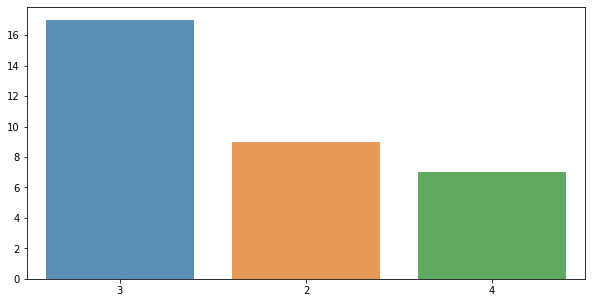

In [23]:
Period_Count =\
df.period.value_counts(sort=True).nlargest(3)
plt.figure(figsize=(10,5))
sns.barplot(Period_Count.index,
Period_Count.values, alpha=0.8)
plt.show()

In [24]:
df9 = df[df['period'] != '2'].copy()
df9['div_rnk'] = df9.mkt_pct.rank(ascending=False)
df9['amt_rnk'] = df9.mkt_amt.rank(ascending=False)
df9_out = df9[colt].sort_values('div_rnk')
df9_tab = pn.widgets.Tabulator(df9_out, layout='fit_data', width=900)
df9_tab

Tabulator(layout='fit_data', value=      name  shares  ..., width=900)

In [25]:
short_term = (df.period == '4')
df.loc[short_term].head().style.format(format_dict)

,name,shares,unit_cost,dividend,mkt_price,period,cost_amt,mkt_amt,div_amt,cost_pct,mkt_pct,pft_pct,div_rnk,amt_rnk
27,BGRIM,"9,000",40.00,0.4500,35.00,4,"360,000.00","315,000.00","4,050.00",1.12%,1.29%,-12.50%,26.0,12.5
28,LPF,"10,000",14.00,0.7284,12.90,4,"140,000.00","129,000.00","7,284.00",5.20%,5.65%,-7.86%,12.0,30.0
29,NER,"36,000",7.45,0.2200,7.15,4,"268,200.00","257,400.00","7,920.00",2.95%,3.08%,-4.03%,17.0,20.0
30,RJH,"4,500",33.00,1.7000,32.75,4,"148,500.00","147,375.00","7,650.00",5.15%,5.19%,-0.76%,15.0,27.0
31,TSTH,"75,000",1.50,nan,1.38,4,"112,500.00","103,500.00",nan,nan%,nan%,-8.00%,nan,33.0


In [26]:
data = df.loc[short_term]
names = data['name']
in_p = ", ".join(map(lambda name: "'%s'" % name, names))
in_p

"'BGRIM', 'LPF', 'NER', 'RJH', 'TSTH', 'TU', 'WHART'"

In [27]:
sql = '''
SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN (%s)'''
sql = sql % in_p
print(sql)

stocks = pd.read_sql(sql, conmy)
stocks.set_index('name',inplace=True)
stocks


SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN ('BGRIM', 'LPF', 'NER', 'RJH', 'TSTH', 'TU', 'WHART')


,min,price,max
name,,,
BGRIM,34.50,35.00,52.50
LPF,10.30,12.90,17.10
NER,4.54,7.15,8.65
RJH,24.40,32.75,39.00
TSTH,0.62,1.38,2.44
TU,13.40,21.10,23.00
WHART,10.68,11.70,14.08


In [28]:
#stocks.drop('SCC',inplace=True)
#stocks

<AxesSubplot:xlabel='name'>

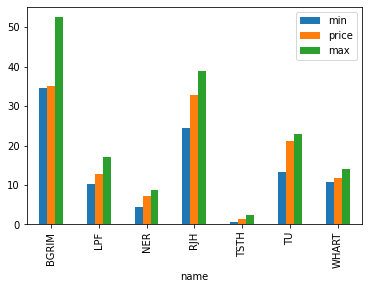

In [29]:
stocks.plot.bar()

In [30]:
#stocks.reset_index('name',inplace=True)
#sns.barplot(x='name', y='price', data=stocks)

### Portfolio cumulative sum by period, name

In [31]:
colw = 'period name shares unit_cost cost_amt mkt_amt cumsum'.split()
df['cumsum'] = df.groupby('period')['mkt_amt'].cumsum()
df[colw].sort_values(by=['period','name'],ascending=[True,True]).style.format(format_dict)

,period,name,shares,unit_cost,cost_amt,mkt_amt,cumsum
0,1,PTTGC,"6,000",64.75,"388,500.00","340,500.00","340,500.00"
1,2,DIF,"60,000",14.70,"882,000.00","858,000.00","858,000.00"
2,2,HREIT,"30,000",8.95,"268,500.00","264,000.00","1,122,000.00"
3,2,JASIF,"100,000",10.00,"1,000,000.00","1,050,000.00","2,172,000.00"
4,2,MCS,"55,000",16.70,"918,500.00","803,000.00","2,975,000.00"
5,2,NOBLE,"63,000",7.00,"441,000.00","387,450.00","3,362,450.00"
6,2,RATCH,"9,000",45.75,"411,750.00","400,500.00","3,762,950.00"
7,2,STA,"20,000",34.75,"695,000.00","585,000.00","4,347,950.00"
8,2,TISCO,"2,000",97.50,"195,000.00","196,000.00","4,543,950.00"
9,2,TMT,"27,000",10.50,"283,500.00","272,700.00","4,816,650.00"
